In [1]:
%matplotlib inline
import proplot as pplt # plotting
import numpy as np # might be useful
import pandas as pd # for reading the csv files
import datetime as dt # for date handling
#import PyCO2SYS as pyco2 # Carbon Chemistry
import BG.readDat as rd # reading the files
from datetime import datetime
#import cftime as cft
import xarray as xr
from matplotlib import pyplot as plt
import cartopy.feature as cfeature
import os

# read files
dsm = xr.open_dataset('OUTPUT/Michel_2021_NAA.nc')
# read some of the files from Amundsen Science (for now)
files = os.listdir('OUTPUT/AMS/')
file_list =[]
for l in range(0,len(files)):file_list.append('OUTPUT/AMS/' + files[l]) 
dsa = xr.open_mfdataset(file_list)
gldp = xr.open_dataset('DATA/OBS_Clean/GLODAP_22.nc') 
dsc = xr.open_dataset('DATA/OBS_Clean/CROW_NAA_deptht.nc')
ncds = xr.open_dataset('DATA/NAA_Area_Volume.nc') # read a file that contatis NAA info
#dsa

In [2]:
dsm = dsm.drop_vars('Stat_id')
dsm = dsm.rename({'Station': 'Station_id'})

In [3]:
dsa = dsa.drop_vars('Stat_id')
dsa = dsa.rename({'Station': 'Station_id'})

In [4]:
print(list(dsa.coords))
print(list(dsc.coords))
print(list(dsm.coords))
print(list(gldp.coords))

['Station_id', 'NAA_deptht']
['NAA_Deptht', 'Stat_id']
['NAA_deptht', 'Station_id']
['NAA_Deptht', 'Stat_id']


In [5]:
dsc = dsc.rename({'Stat_id': 'Station_id'})

In [6]:
gldp = gldp.rename({'Stat_id': 'Station_id'})

In [7]:
#socat = xr.open_dataset('DATA/OBS/SOCAT_2022/SOCATv2022_tracks_gridded_monthly.nc')
#socat

In [8]:
#function definition: 

def dataframe_creator(ds):
  # now go through Stations in OBS- Dataset and get the inices for the gridcells
  ## I want a table with Station ID as one Column and a list of Inices as second Column
  df = pd.DataFrame(columns = ['Station_ID', 'X_NAA', 'Y_NAA', 'Lon', 'Lat'])#, 'Month', 'Year'])
  for i in range(0, len(ds['Station_id'])):
    dslice = ds.isel(Station_id = i)
    A = str(dslice.coords['Station_id'].values)
    B = np.array(dslice['X_NAA'])
    C = np.array(dslice['Y_NAA'])
    D = float(dslice.Longitude.values)
    E =float(dslice.Latitude.values)
    
    dummy = pd.DataFrame({'Station_ID': A, 'X_NAA':B, 'Y_NAA':C, 'Lon':D, 'Lat':E}, index = [i]) #'Month':F, 'Year':G 
    df = df.append( dummy )
    
  return(df)


In [19]:

# Create Masks from NAA grid for the OBS
ds = dsm
output_name = 'OUTPUT/OBS_mask-mea.nc'
# get list of stations from OBS-DS
df = dataframe_creator(ds)
#df

length = len(df.Station_ID)
#turn the list objects from X_NAA/ Y_NAA into indices
# If there are two entries for each, dublicate the row in the Dataframe
coord_df = pd.DataFrame(columns = ['Station_ID', 'y_naa', 'x_naa'])
for i in [*range(0,length,1)]: # 5)]:#
  slice = df.iloc[i,:] # get a sinlge row -> dataslice
  # I want a list of 
  # build in a switch to catch those things where double gridcells exist.
  Y = slice['Y_NAA']
  y = np.array(Y)
  if ',' in Y: 
    yflag, yf= True, 1
    l = Y.split(',')
    if len(l) == 2 : 
      o = 2
      y = int(l[0][1:])
      y1 = int(l[1][:-1])
      # Cant have them as pandas yet, dct first. Need to keep the x and y together, otherwise I am making a mess
      d0 = pd.DataFrame({'Station_ID': slice['Station_ID'], 'y_naa': y}, index = [i])
      d1 = pd.DataFrame({'Station_ID': slice['Station_ID'], 'y_naa': y1}, index = [i])
    elif len(l) ==3 :  
      o = 3 
      y = int(l[0][1:])
      y1 = int(l[1])
      y2 = int(l[2][:-1])
      # Cant have them as pandas yet, dct first. Need to keep the x and y together, otherwise I am making a mess
      d0 = pd.DataFrame({'Station_ID': slice['Station_ID'], 'y_naa': y}, index = [i])
      d1 = pd.DataFrame({'Station_ID': slice['Station_ID'], 'y_naa': y1}, index = [i])
      d2 = pd.DataFrame({'Station_ID': slice['Station_ID'], 'y_naa': y2} , index = [i]) 
  else:
    yflag, yf = False, 0
    try: 
      o= 1
      y =int(Y[1:-1]) # need to get things out of the '[aaa]'state into an actual integer.
      d0 = pd.DataFrame({'Station_ID': slice['Station_ID'], 'y_naa': y}, index =[i])
      #d1 = {'Station_ID': slice['Station_ID'], 'y_naa': y}
    except:
      y = 0   
  
  X = slice['X_NAA']
  x = np.array(X)
  if ',' in Y: 
    xflag, xf= True, 1
    l = X.split(',')
    if len(l) == 2 : 
      x = int(l[0][1:])
      x1 = int(l[1][:-1])
      # Cant have them as pandas yet, dct first. Need to keep the x and y together, otherwise I am making a mess
      d0['x_naa'] = x
      d1['x_naa'] = x1
    elif len(l) ==3 :   
      x = int(l[0][1:])
      x1 = int(l[1])
      x2 = int(l[2][:-1])
      # Cant have them as pandas yet, dct first. Need to keep the x and y together, otherwise I am making a mess
      d0['x_naa'] = x
      d1['x_naa'] = x1
      d2['x_naa'] = x2    
  else:
    xflag, xf = False, 0
    try: 
      x =int(X[1:-1]) # need to get things out of the '[aaa]'state into an actual integer.
      d0['x_naa'] = x
      #d1['x_naa'] = x
    except:
      y = 0
  
  if o ==1 : 
    coord_df = coord_df.append(d0)  
  elif o ==2: 
    coord_df = coord_df.append( [d0,d1] )  
  elif o==3:
      coord_df = coord_df.append([d0,d1,d2] )  
  #print(d0)    
  #print(d1)    
#  dummy0 = pd.DataFrame(d0, index = [i])
#  dummy1 = pd.DataFrame(d1, index = [i]) 
  


# group by x_naa and get a list of unique y_naa values(keep int) 
si= coord_df.groupby('Station_ID')
si_list = list(si.groups) # Y_list contains all the indices for the Y axis.
mask = np.full(shape = (400, 568), fill_value= 'none', dtype = 'object') 
n_obs = np.zeros(shape = mask.shape)
c = 0
for g in range(0,len(si_list)): 
  sig = si.get_group(si_list[g])
  #print(str(sig.Station_ID.iloc[0]))
  ylist  = list(sig['y_naa'].unique())
  xlist  = list(sig['x_naa'].unique())
  
  if ylist[0] < 999: # 999 is used as nan in AMS-Dataset
    if xlist[0] < 999: 
      mask[ylist,xlist] = mask[ylist,xlist] + ' ; ' +str(sig.Station_ID.iloc[0])
      n_obs[ylist,xlist] = n_obs[ylist,xlist] + 1
    else:  pass #print('x ', xlist[0] )  
  else: c = c+1#pass# print('y ', ylist[0] ) 
print('nans: ',c)
print('total Stations: ', len(si_list))
#coord_df
# this works neatly. 
out_ds = xr.Dataset({'mask': (['y','x'], mask),
                     'n_obs': (['y','x'], n_obs)},
            coords = {'nav_lon': ncds.nav_lon,
                      'nav_lat': ncds.nav_lat}, 
            attrs={'script': 'created with create_obs_mask.ipynb -- JLanger',
             'cluster': 'Aeolus - Uvic',
              'creation Date--time': str(datetime.now())})

out_ds.to_netcdf(output_name)

nans:  0
total Stations:  117


In [15]:
len(si_list)

2007

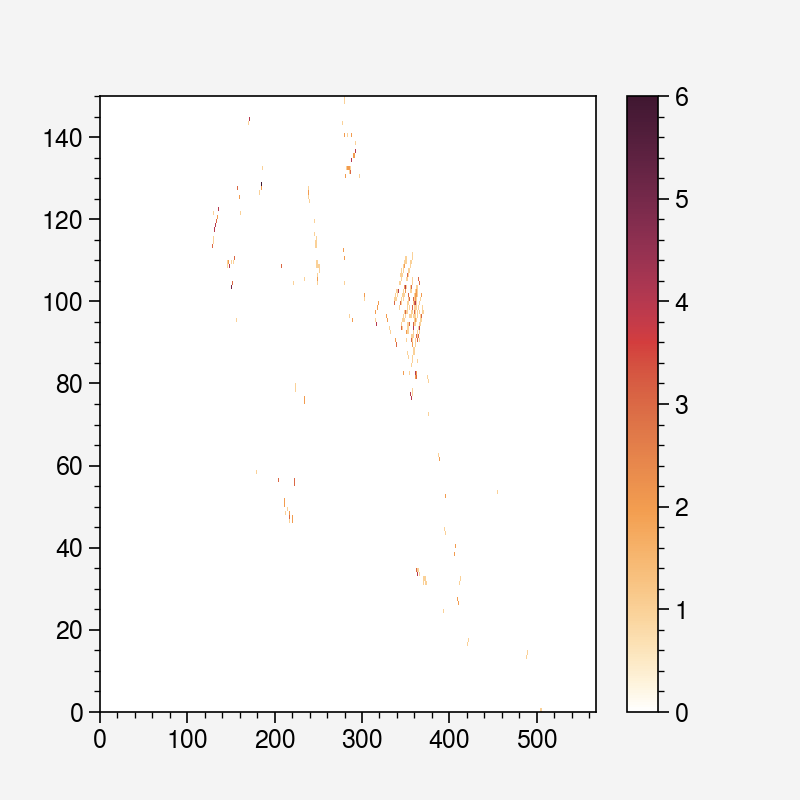

In [10]:
plt.pcolormesh(out_ds.n_obs[:150,:])
plt.colorbar()

In [11]:
stop

NameError: name 'stop' is not defined

In [ ]:
test = dataframe_creator(dsa)
test

,Station_ID,X_NAA,Y_NAA,Lon,Lat
0,2004-01_AMS_CDT_2004001_001,"[144, 145]","[96, 97]",-126.3017,70.0455
1,2004-01_AMS_CDT_2004001_002,"[144, 145]","[96, 97]",-126.3015,70.0455
2,2004-01_AMS_CDT_2004001_003,"[144, 145]","[96, 97]",-126.3015,70.0455
3,2004-01_AMS_CDT_2004001_004,"[144, 145]","[96, 97]",-126.3015,70.0455
4,2004-01_AMS_CDT_2004001_005,"[144, 145]","[96, 97]",-126.3015,70.0455
...,...,...,...,...,...
2007,2020-10_AMS_CDT_2020003_001,"[383, 384, 383]","[29, 29, 30]",-65.6400,62.1462
2008,2020-10_AMS_CDT_2020003_002,"[387, 386]","[30, 31]",-64.9487,62.0328
2009,2020-10_AMS_CDT_2020003_003,"[396, 396]","[30, 31]",-63.5306,61.4916
2010,2020-10_AMS_CDT_2020003_004,"[391, 392, 391]","[30, 30, 31]",-64.3015,61.7103


In [ ]:
fu = df.loc[df['Station_ID'] =='2020-10_AMS_CDT_2020003_001']
fu

,Station_ID,X_NAA,Y_NAA,Lon,Lat
2007,2020-10_AMS_CDT_2020003_001,"[383, 384, 383]","[29, 29, 30]",-65.64,62.1462


In [ ]:
Y = str(fu['Y_NAA']) 
y = np.array(Y)
if ',' in Y: 
  yflag, yf= True, 1
  l = Y.split(',')
  
  print('l',  l)
  #y = int(l[0][1:])
  

l ['2007    [29', ' 29', ' 30]\nName: Y_NAA', ' dtype: object']


ValueError: invalid literal for int() with base 10: '007    [29'

In [ ]:
#print(Y)
#print(y) #class 'numpy.str_' vs <class 'pandas.core.series.Series'>
l[1]

' 29'